In [1]:
# Library imports
import torch
import math
import random

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

from IPython import display

from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import BertModel, BertConfig

c:\Users\erwin\miniconda3\envs\stega\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Determine what device to use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    device_name = torch.cuda.get_device_name(device)

    print(f'CUDA on {device_name}')
else:
    print(f'CPU')

CUDA on NVIDIA RTX 500 Ada Generation Laptop GPU


In [3]:
# Configuration parameters

SECRET_LENGTH = 16
TOKENS_PER_BIT = 1
INJECT_SECRET_IN_SYSTEM_PROMPT = False 	# Whether to insert the secret as binary text in the system prompt. Didn't show any effect in early tests

STEGO_LENGTH = SECRET_LENGTH * TOKENS_PER_BIT

# Training parameters

MAX_EPOCH = 100                         # Maximum number of training epochs
TEST_FRACTION = 0.25                    # Fraction of data to use for testing 

LR_INITIAL = 5.0						# Initial learning rate
LR_GAMMA = 0.97	    					# Learning rate decay factor per epoch

RECOVERY_LOSS_ALPHA_START = 0.95 	    # Weighting factor for recovery loss vs semantic loss at the start of training (0.0 to 1.0)
RECOVERY_LOSS_ALPHA_END = 0.8			# Weighting factor for recovery loss vs semantic loss at the end of training (0.0 to 1.0)
RECOVERY_LOSS_STEPS = 80            	# Number of steps over which to linearly anneal the recovery loss weight

EXAMPLE_OUTPUT_INTERVAL = 10             # Number of steps between updating example output texts. This is pretty slow so lowering this will slow down training.


In [4]:
# Prompt templates

INPUT_PROMPT = 'Explain {0}.'
INPUT_SUBJECTS = [
	'neural networks',
	'electric cars',
	'wireless internet',
	'natural selection',
	'special relativity',
	'progressive taxes',
    'stock trading',
    'marginal costs',
    'social benefits',
    'digital cameras',
    'quantum computing',
    'renewable energy',
    'blockchain technology',
    'virtual reality',
    'social media',
    'digital literacy',
]

In [5]:
# Cleanup previous run
# This allows rerunning the entire notebook without memory leaks

import gc

# Delete models, clean up memory

if 'generator_tokenizer' in globals():
    del generator_tokenizer # type: ignore
    
if 'generator' in globals():
    del generator # type: ignore
    
if 'encoder' in globals():
    del encoder # type: ignore
    
if 'decoder' in globals():
    del decoder # type: ignore
    
if 'vocab_mask' in globals():
    del vocab_mask # type: ignore

gc.collect()

torch._C._cuda_clearCublasWorkspaces()
torch.cuda.empty_cache()


In [6]:
# Check if everything's cleaned
allocated = torch.cuda.memory_allocated() / (1024 * 1024)
reserved = torch.cuda.memory_reserved() / (1024 * 1024)

print(f'Allocated: {allocated:.1f} MB; Reserved: {reserved:.1f} MB')

Allocated: 0.0 MB; Reserved: 0.0 MB


In [7]:
# Vocab Mask Definition

class LearnableVocabMask(torch.nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.mask_logits = torch.nn.Parameter(
            # Mask value of 5.0 gives an initial gate value of close to 1
            torch.full((vocab_size,), 5.0)
        )

    def forward(self, logits, mask_polarity, eps=1e-8):
        gate = torch.sigmoid(self.mask_logits)
        
        # Invert gate based on mask polarity
        # Some arithmetic to map (0,1) to (-1,1), apply polarity, then map back to (0,1)
        gate = ((gate * 2 - 1) * mask_polarity) * 0.5 + 0.5

        return logits + torch.log(gate + eps)
    
    def classify(self, token_probs):
        gate = torch.sigmoid(self.mask_logits)                  # [ V ]
        masked_probs = token_probs * gate.reshape(1, 1, -1)     # [ B, T, V ]

        # Determine the attenuation on the probabilities by re-applying the mask
        # If probabilities are not damped by a lot, the bit is likely 1. If they
        # are heavily damped, the bit is likely 0.
        p = masked_probs.sum(dim=-1) # [ B, T ]
        return p

In [8]:
# Stego Encoder Model Definition

class StegoEncoder(nn.Module):
    def __init__(self, base_lm, vocab_mask = None):
        super().__init__()
        
        self.base_lm = base_lm
        self.vocab_mask = vocab_mask
        self.vocab_size = base_lm.config.vocab_size
        
        # Freeze base model
        for p in self.base_lm.parameters():
            p.requires_grad = False

    def generate_input_embeddings(self, input_ids, secret_bits = None):
        # Token embeddings based on input tokens
        token_embeds = self.base_lm.get_input_embeddings()(input_ids) # (B, T, D)
        return token_embeds

    def kl_semantic_loss(self, stego_logits, base_logits):
        """Compute KL divergence between stego and base logits as semantic loss."""
        p = F.log_softmax(stego_logits, dim=-1)
        q = F.softmax(base_logits, dim=-1)

        return F.kl_div(p, q, reduction="batchmean")

    def mask_indices(self, logits, bits):
        """Mask out subsets of tokens based on the secret bit. Trivial encoding scheme for debugging."""

        # Create a mask to mask out subsets of tokens
        logit_mask = torch.full((self.vocab_size,), True)
        
        for b in range(bits.size(0)):
            # bit = 0: mask even tokens
            # bit = 1: mask odd tokens
            bit_val = bits[b].item() == 1

            logit_mask[range(0, self.vocab_size, 2)] = not bit_val
            logit_mask[range(1, self.vocab_size, 2)] = bit_val

            # Mask out tokens we don't allow
            logits[b, ~logit_mask] = -math.inf

    def forward(self, secret_bit = None, temperature=1.0, **kwargs):
        out = self.base_lm(
            **kwargs,
            return_dict=True,
            use_cache=True,
            eos_token_id=None, # prevent early stop
        )

        # Select logits for the last token only (this is the next prediction)
        logits = out.logits[:, -1, :]   # [B, V]

        # Encode secret bit based on vocab mask
        if secret_bit is not None:
            batch_secret = secret_bit.unsqueeze(1)  # [B, 1]

            # Apply learned vocab mask
            if self.vocab_mask is not None:
                masked_logits = self.vocab_mask(logits, batch_secret * 2 - 1)
            else:
                masked_logits = logits
        else:
            masked_logits = logits

        # Softmax to convert from logits to probabilities
        probs = torch.softmax(masked_logits / temperature, dim=-1)

        return masked_logits, logits, probs, out.past_key_values

    def soft_embeddings(self, token_probs):
        embed_matrix = self.base_lm.get_input_embeddings().weight  # [V, d]
        return token_probs @ embed_matrix


In [9]:
# Stego Decoder Model Definition

class StegoDecoder:
    def __init__(self, vocab_mask):
        self.vocab_mask = vocab_mask

    def classify(self, token_probs=None, labels=None):
        # Perform classification to get logits for each bit
        probs = self.vocab_mask.classify(token_probs)

        loss = None
        if labels is not None:
            loss_fn = nn.BCELoss()
            loss = loss_fn(probs, labels.float())

        return {
            "loss": loss,
            "probs": probs,
        }


In [10]:
# Create LM models

#GENERATOR_MODEL = "Qwen/Qwen3-0.6B"
#GENERATOR_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
#GENERATOR_MODEL = "HuggingFaceTB/SmolLM2-360M-Instruct"
GENERATOR_MODEL = "HuggingFaceTB/SmolLM2-135M-Instruct"

generator_tokenizer = AutoTokenizer.from_pretrained(GENERATOR_MODEL)
generator = AutoModelForCausalLM.from_pretrained(GENERATOR_MODEL).to(device)

# Print model info
embedding_size = generator.config.hidden_size
vocab_size = generator.config.vocab_size
print(f'Generator embedding dimensions: {embedding_size}, vocabulary size: {vocab_size}')

Generator embedding dimensions: 576, vocabulary size: 49152


In [11]:
# Create decoder & decoder model

vocab_mask = LearnableVocabMask(vocab_size=vocab_size).to(device)
vocab_mask.train()

encoder = StegoEncoder(base_lm=generator, vocab_mask=vocab_mask).to(device)
encoder.train()

decoder = StegoDecoder(vocab_mask)

In [12]:
# Utility functions

def generate_secret(batch_size=1):
    """Generate a random binary secret."""
    return torch.randint(0, 2, (batch_size, SECRET_LENGTH))   # [ B, N ]

def bits_to_str(bits, sep=''):
    """Convert a bit tensor to a string representation."""
    return sep.join(str(b) for b in bits.tolist())

def calculate_accuracy(preds, targets):
    """Calculate bitwise accuracy between predictions and targets."""
    correct = (preds == targets).sum().item()
    total = targets.numel()
    return correct / total

def generate_carrier_prompt(subject_set=INPUT_SUBJECTS):
    """Generate a random carrier prompt."""
    subject = np.random.choice(subject_set)
    return INPUT_PROMPT.format(subject)

def generate_carrier_prompts(subject_set=INPUT_SUBJECTS):
    """Generate the full training set of carrier prompts."""
    return [ INPUT_PROMPT.format(subject) for subject in subject_set ]

def build_generator_prompt(carrier, secret_bits = None):
    """Build the prompt for the generator model, optionally injecting the secret in the system prompt."""
    messages = [ ]

    if INJECT_SECRET_IN_SYSTEM_PROMPT and secret_bits is not None:
        messages.append(
            {'role': 'system', 'content': f'You are a helpful assistant who always encodes these bits in their answer: {bits_to_str(secret_bits.flatten(), " ")}. '}
        )

    messages.append({'role': 'user', 'content': carrier })

    return generator_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

@torch.no_grad()
def encode(carrier, secret_bits):
    """End-to-end encoding of secret bits into generated stego text based on the carrier prompt."""
    prompt = build_generator_prompt(carrier, secret_bits)
    inputs = generator_tokenizer(prompt, return_tensors="pt")

    input_embeddings = encoder.generate_input_embeddings(inputs.input_ids.to(device), secret_bits)
    past_kv = None

    # Generate N tokens, store ids for each token
    selected_tokens = [ ]
    for t in range(STEGO_LENGTH):   
        stego_logits, original_logits, token_probs, past_kv = encoder(
            secret_bit = secret_bits[:, t],
            inputs_embeds=input_embeddings,
            past_key_values=past_kv
        )

        # Select the top probability token
        predictions = torch.argmax(token_probs, dim=-1)

        # Convert the token to 'hard' embeddings again for the next iteration
        embedding_layer = generator.get_input_embeddings()
        input_embeddings = embedding_layer(predictions).unsqueeze(1) # (B, 1, D)
        
        selected_tokens.append(predictions[0])

    return generator_tokenizer.decode(selected_tokens, skip_special_tokens=True)

@torch.no_grad()
def decode(stego_text):
    """End-to-end decoding of stego text to recover the secret bits."""
    encoded_token_ids = generator_tokenizer(stego_text, return_tensors="pt").input_ids
    
    # Ensure correct length, discard extra tokens and pad if too short
    encoded_token_ids = encoded_token_ids[:, :STEGO_LENGTH]
    encoded_token_ids = F.pad(encoded_token_ids, (0, STEGO_LENGTH - encoded_token_ids.shape[1]), value=generator_tokenizer.pad_token_id)

    encoded_token_probs = F.one_hot(encoded_token_ids, vocab_size).float().to(device)

    out = decoder.classify(
        token_probs = encoded_token_probs,
    )

    probs = out["probs"]      # (B, N, 1)
    preds = (probs.squeeze(-1) > 0.5).long()
    
    return preds[0]


In [13]:
# Test prompt generation and generation inference

# Prepare carrier and secret into a prompt
carrier = generate_carrier_prompt()
secret = generate_secret().to(device)

print('Generator prompt:')
print(build_generator_prompt(carrier, secret))

print('----------------')
print()

# Encode the secret into stego text
stego = encode(carrier, secret)
decoded = decode(stego)

print(f'Stego:    {stego}')
print(f'Original: {bits_to_str(secret[0])}')
print(f'Decoded:  {bits_to_str(decoded)}')

Generator prompt:
<|im_start|>system
You are a helpful AI assistant named SmolLM, trained by Hugging Face<|im_end|>
<|im_start|>user
Explain special relativity.<|im_end|>
<|im_start|>assistant

----------------

Stego:    Special relativity is a fundamental theory in physics that describes the relationship between the laws of
Original: 0101001100011001
Decoded:  1111111111111111


In [14]:
# Training helpers

def loss_schedule(epoch, max_epoch):
    """Linearly anneal recovery loss weight over time."""
    p = min(epoch / RECOVERY_LOSS_STEPS, 1.0)
    alpha = RECOVERY_LOSS_ALPHA_START + (RECOVERY_LOSS_ALPHA_END - RECOVERY_LOSS_ALPHA_START) * p
    return alpha, 1.0 - alpha

def split_train_test(prompts, test_fraction):
    """Split prompts into training and testing sets."""
    indices = list(range(len(prompts)))
    random.shuffle(indices)

    test_size = int(len(prompts) * test_fraction)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    test_prompts = [ prompts[i] for i in test_indices ]
    train_prompts = [ prompts[i] for i in train_indices ]

    return train_prompts, test_prompts

In [15]:
# Training loop

# Collect all model parameters
collect_params = lambda model: [ p for p in model.parameters() if p.requires_grad ]

parameters = [ ]
parameters += collect_params(encoder) # Note: vocab_mask parameters are already included in encoder

# Initialize optimizer to guide training
optimizer = torch.optim.AdamW(parameters, lr=LR_INITIAL)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=LR_GAMMA)

# Prepare prompts
print('Preparing training prompts...')

carrier_prompts = generate_carrier_prompts()
train_prompts, test_prompts = split_train_test(carrier_prompts, test_fraction=TEST_FRACTION)

generator_prompts = [ build_generator_prompt(carrier) for carrier in train_prompts ]
generator_inputs = generator_tokenizer(generator_prompts, return_tensors="pt", padding=True).input_ids.to(device)

print('Generator inputs shape:', generator_inputs.shape)

# Training loop for fixed number of steps
print('Starting training...')

batch_size = len(train_prompts)
test_size = len(test_prompts)
train_stats = [ ]

for step in range(MAX_EPOCH):
    secret_bits = generate_secret(batch_size).to(device)

    # Prepare embeddings for first step by adding secret prefix to token embeddings
    # NOTE: when not using prefix embeddings, these are constant and could be pre-generated
    soft_embeds = encoder.generate_input_embeddings(generator_inputs, secret_bits)
    past_kv = None

    # Generate N tokens, store probabilities for each token
    generated_token_probs = []

    # Initialize semantic loss, which we accumulate per generated token
    semantic_loss = 0.0

    for t in range(STEGO_LENGTH): 
        stego_logits, original_logits, token_probs, past_kv = encoder(
            secret_bit=secret_bits[:, t],
            inputs_embeds=soft_embeds,
            past_key_values=past_kv
        )

        # Calculate semantic loss compared to base logits
        semantic_loss += encoder.kl_semantic_loss(stego_logits, original_logits)

        # Prepare soft embeddings for next step
        soft_embeds = encoder.soft_embeddings(token_probs)  # [ B, D ]

        # Store all generated token probabilities
        generated_token_probs.append(token_probs)

        # Take soft embeds for next step
        soft_embeds = soft_embeds.unsqueeze(1)

    # Stack probabilities for each token to [ B, N, D ]
    encoder_outputs_probs = torch.stack(generated_token_probs, dim=1).to(device)

    # Calculate recovery loss based on decoding success
    recovery_loss = decoder.classify(
        token_probs=encoder_outputs_probs, 
        labels=secret_bits.to(device)
    )['loss']

    # Combine loss based on loss weighting schedule
    w_recovery, w_semantic = loss_schedule(step, MAX_EPOCH)
    loss = w_recovery * recovery_loss + w_semantic * semantic_loss

    # Calculate loss gradients
    loss.backward()

    # Backpropagation, reset gradients and update parameters
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()

    # Only update example texts and accuracy every X steps, as they're pretty slow to compute
    if step % EXAMPLE_OUTPUT_INTERVAL == 0:
        acc = 0
        stego_texts = [ ]
        recovered_secrets = [ ]
        secret_bits = generate_secret(test_size).to(device)

        # Calculate accuracy on test set
        for t in range(test_size):
            # Encode and decode the test sample
            stego_text = encode(test_prompts[t], secret_bits[t].unsqueeze(0))
            decoded_secret_bits = decode(stego_text)
            
            # Calculate secret recovery accuracy
            sample_acc = calculate_accuracy(decoded_secret_bits, secret_bits[t])
            acc += sample_acc / test_size

            # Keep the example texts for display
            stego_texts.append(stego_text)
            recovered_secrets.append(decoded_secret_bits)

    output = ''
    output += f'Step {step}\n'
    output += f'------------------------------------------------------\n'
    output += f'L_sem: {semantic_loss.item():.3f} | L_rec: {recovery_loss.item():.3f} | Acc: {acc:.3f}\n'
    output += f'Lr: {scheduler.get_last_lr()[0]:.6f} | w_rec: {w_recovery:.3f} | w_sem: {w_semantic:.3f}\n'
    output += '\n'

    debug_index = random.randint(0, test_size - 1)
    output += f'Example output (only updated every {EXAMPLE_OUTPUT_INTERVAL} steps):\n'
    output += f'Prompt:            {test_prompts[debug_index]}\n'
    output += f'Stego:             {stego_texts[debug_index]}\n'
    output += f'Original secret:   {bits_to_str(secret_bits[debug_index])}\n'
    output += f'Recovered secret:  {bits_to_str(recovered_secrets[debug_index])}\n'
    output += '\n'

    # Print debug text
    display.clear_output(wait=True)
    print(output)

    # Track stats
    train_stats.append({
        'step': step,
        'l_sem': semantic_loss.item(),
        'l_rec': recovery_loss.item(),
        'acc': acc,
    })

Step 99
------------------------------------------------------
L_sem: 26.369 | L_rec: 0.179 | Acc: 0.828
Lr: 0.237763 | w_rec: 0.800 | w_sem: 0.200

Example output (only updated every 10 steps):
Prompt:            Explain social media.
Stego:             Social media is a digital platform that connects people worldwide through the exchange and sharing of
Original secret:   1001010010001101
Recovered secret:  0011011110101011




In [16]:
# Prepare data for stats
import pandas as pd
df_stats = pd.DataFrame(train_stats)

df_stats.head()

,step,l_sem,l_rec,acc
0,0,1.178713e-07,2.636930,0.453125
1,1,2.171504e+00,0.669967,0.453125
2,2,7.833249e+00,0.591900,0.453125
3,3,1.241622e+01,0.367777,0.453125
4,4,2.529335e+01,0.330051,0.453125


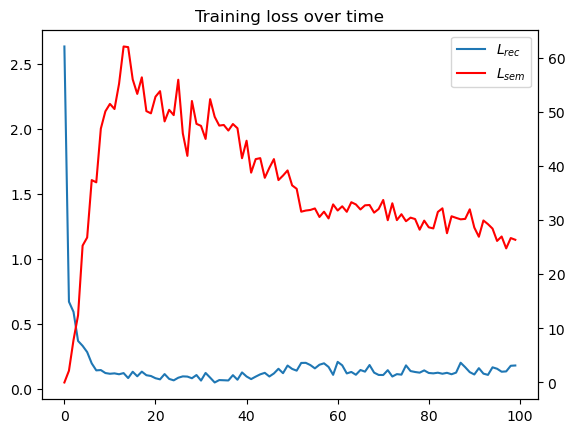

In [17]:
# Plot loss over time

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

plot_rec = ax1.plot(df_stats['step'], df_stats['l_rec'], label='$L_{rec}$')

ax2 = ax1.twinx()
plot_sem = ax2.plot(df_stats['step'], df_stats['l_sem'], label='$L_{sem}$', c='red')

plots = plot_rec + plot_sem

ax1.set_title('Training loss over time')
ax1.legend(plots, [ l.get_label() for l in plots ])

plt.show()

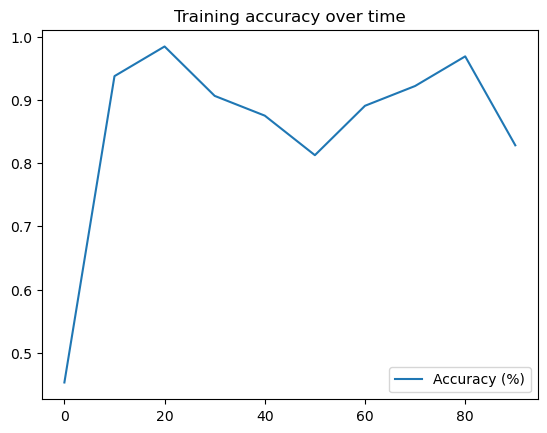

In [22]:
# Plot accuracy over time

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

df_acc = df_stats[df_stats['step'] % EXAMPLE_OUTPUT_INTERVAL == 0]
ax1.plot(df_acc['step'], df_acc['acc'], label='Accuracy (%)')

ax1.set_title('Training accuracy over time')
ax1.legend()

plt.show()

In [29]:
# Final end-to-end test

carrier = generate_carrier_prompt(subject_set=INPUT_SUBJECTS)
secret = generate_secret().to(device)

stego_text = encode(carrier, secret)
recovered_secret = decode(stego_text)

print('Prompt:     ', carrier)

print('Stego text: ', stego_text)
print()
print('Original:   ', bits_to_str(secret[0]))
print('Recovered:  ', bits_to_str(recovered_secret))
print(f'Accuracy:    {100 * calculate_accuracy(recovered_secret, secret):.2f}%')


Prompt:      Explain neural networks.
Stego text:  Neural networks are a powerful mathematical framework used to model complex relationships between different types

Original:    0100101111010111
Recovered:   0000101010010011
Accuracy:    75.00%


In [20]:
# Save model

torch.save(vocab_mask.state_dict(), './models/latest_vocab_mask')